# Team Park Rangers: Forest Classification Kaggle Competition

In [2]:
import math
import csv
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skl
import csv
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics, cross_validation

import seaborn as sns
import matplotlib.cm as cm
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import f1_score

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.model_selection import train_test_split



## 1. Business Understanding (PKB)

- What problem are we trying solve?
- What are the relevant metrics? How much do we plan to improve them?
- What will we deliver?

## 2. Data Understanding (ZY)

- What are the raw data sources?
- What does each 'unit' (e.g. row) of data represent?
- What are the fields (columns)?
- EDA
  - Distribution of each feature
  - Missing values
  - Distribution of target
  - Relationships between features
  - Other idiosyncracies?

#### statistical description

- No missing values. every row can be used.
- Vertical_Distance_To_Hydrology has negative values.
- Wilderness_Area and Soil_Type are one-hot encoded, they could be converted back for some analysis.
- Soil_Type7 and Soil_Type15 can be removed as they are constant (all zeros)
- Scales are not the same for all, rescaling and standardization may be helpful for some algorithms.


In [16]:
data_train = pd.read_csv('train.csv')             # read training data
data_test = pd.read_csv('test.csv')

df_train, df_test = train_test_split(data_train, random_state=1)

# classification is target
target = df_train.columns[-1]
#remove ID
all_features_ALL = df_train.columns[1:-1]

#seperate features by data type
num_features = df_train.columns[1:11]
cat_features_ALL = df_train.columns[11:-1]

#seperate binary features by classification covered
wild_features = df_train.columns[11:15]
soil_features_ALL = df_train.columns[15:-1]


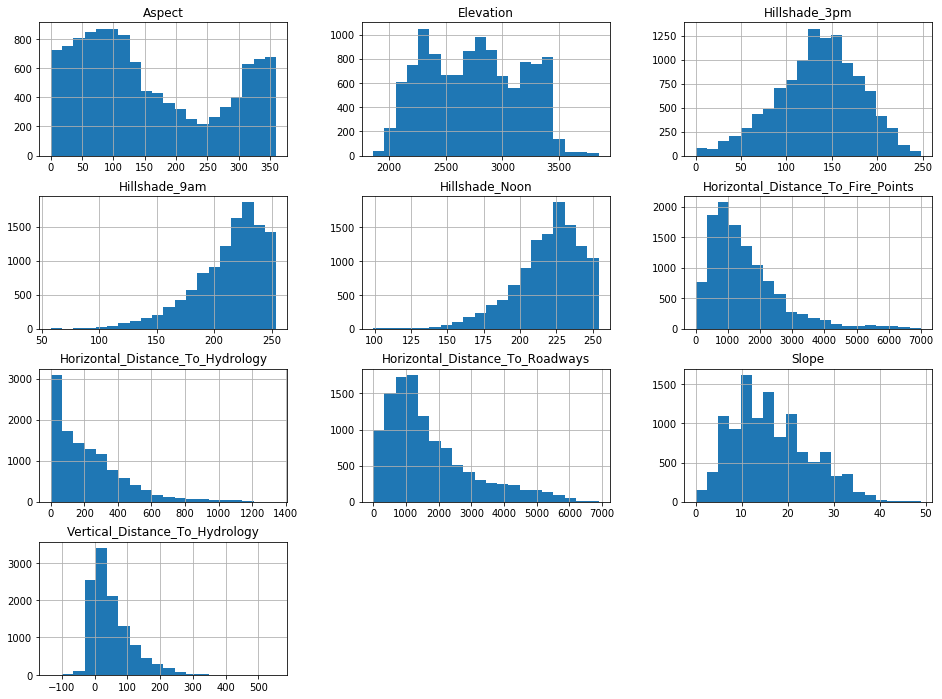

In [6]:
df_train[num_features].hist(figsize=(16,12), bins=20)
plt.show()

#### skew

- values close to 0 show less skew

- several features in Soil_Type show a large skew. Hence, some algorithms may benefit if skew corrected

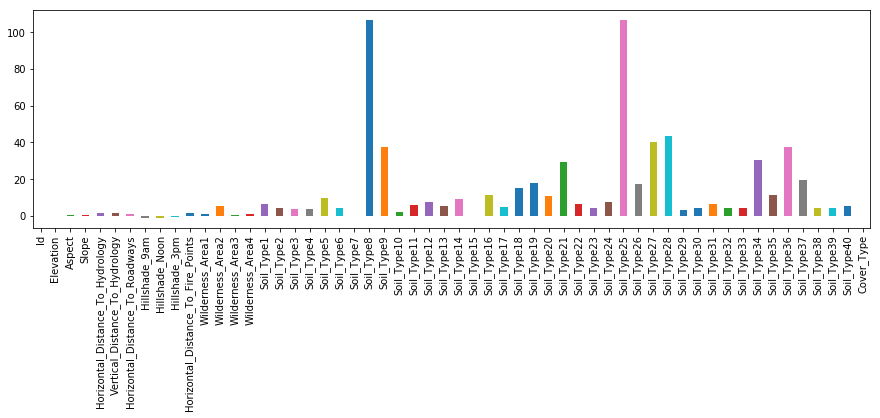

In [7]:
df_train.skew().plot(kind='bar', figsize=(15,4))
plt.show()

#### class distribution

- all classes have the same number, no class-rebalancing is necessary

In [9]:
df_train.groupby('Cover_Type').size()

Cover_Type
1    1608
2    1599
3    1630
4    1597
5    1647
6    1631
7    1628
dtype: int64

### 2.1 Correlations

- Correlation requires continuous data, ignore Wilderness_Area and Soil_Type here.

- strong correlation observed for following pairs, opportunity to reduce features

Hillshade_9am & Hillshade_3pm = -0.78
Horizontal_Distance_To_Hydrology & Vertical_Distance_To_Hydrology = 0.65
Aspect & Hillshade_3pm = 0.63
Hillshade_Noon & Hillshade_3pm = 0.62
Slope & Hillshade_Noon = -0.62
Aspect & Hillshade_9am = -0.59
Elevation & Horizontal_Distance_To_Roadways = 0.58


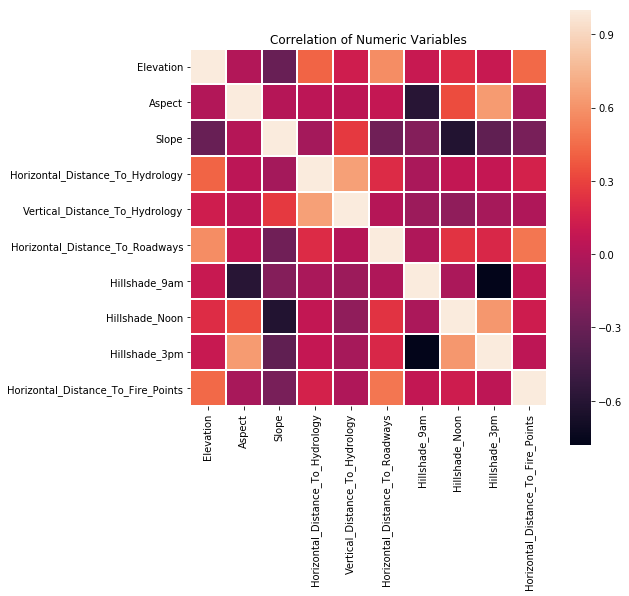

In [13]:
size = num_features.shape[0]         # size: 10 numeric features
num_data = df_train[num_features]    #  selecting numeric features

num_data_cor = num_data.corr()       # correlation matrix

cor_threshold = 0.5                  # threshold for selecting highly correlated features
num_data_cor_high = []               # list for pairs with cor > threshold

# search for highly correlated pairs
for i in range(0, size):
    for j in range(i+1, size):
        if abs(num_data_cor.iloc[i,j]) >= cor_threshold:                  
            num_data_cor_high.append([num_data_cor.iloc[i,j], i, j])  # store correlation
            
# sort to show high ones
num_data_cor_high_sorted = sorted(num_data_cor_high, key = lambda x: -abs(x[0]))

# print correlation and column names
for v, i, j in num_data_cor_high_sorted:
    print("{} & {} = {:.2f}".format(num_features[i], num_features[j], v))

# correlation heat map
fig, ax = plt.subplots(figsize=(8, 8))  
sns.heatmap(num_data_cor, square=True, linewidths=1)
plt.title('Correlation of Numeric Variables')
plt.show()

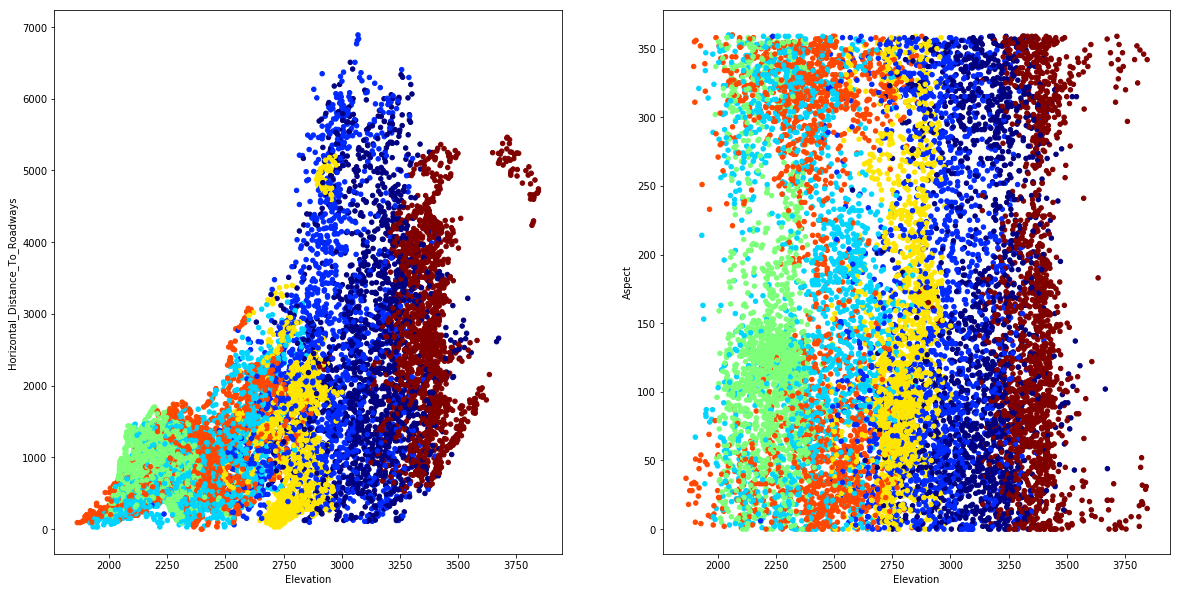

In [14]:
cmap = cm.jet

labels = df_train.Cover_Type

fig, axes = plt.subplots(1, 2, figsize=(20,10))

df_train.plot(kind='scatter', x='Elevation', y='Horizontal_Distance_To_Roadways',
              marker='o', c=labels, cmap=cmap, colorbar=False, ax=axes[0])

df_train.plot(kind='scatter', x='Elevation', y='Aspect', 
              marker='o', c=labels, cmap=cmap, colorbar=False, ax=axes[1])

plt.show()

Wilderness_Area1 2672
Wilderness_Area2 374
Wilderness_Area3 4793
Wilderness_Area4 3501


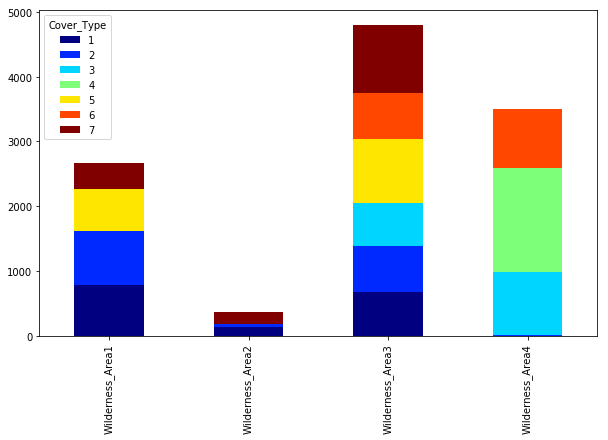

In [15]:
col_names = df_train.columns.tolist()

A = np.array(col_names)

soil_types = [item for item in A if "Soil" in item]
wilderness_areas = [item for item in A if "Wilderness_Area" in item]

# Which wilderness_area support which cover_types?

for wilderness_area in wilderness_areas: print(wilderness_area, df_train[wilderness_area].sum())

wild_areas_sum = df_train[wilderness_areas].groupby(df_train['Cover_Type']).sum()
wild_areas_sum.T.plot(kind='bar', stacked=True, figsize=(10,6), cmap='jet')
plt.show()    

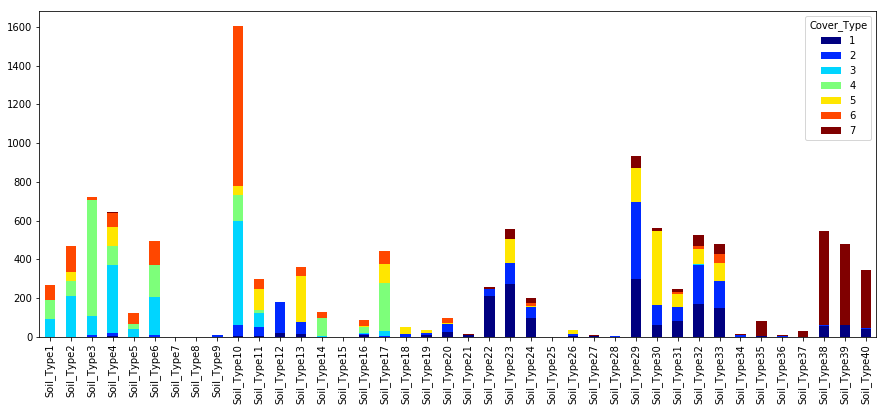

In [17]:
# Which soil_types support which cover_types?

# for soil_type in soil_types: print (soil_type, df_train[soil_type].sum())

types_sum = df_train[soil_types].groupby(df_train['Cover_Type']).sum()
types_sum.T.plot(kind='bar', stacked=True, figsize=(15,6), cmap='jet')
plt.show()

## 3. Data Preparation

- What steps are taken to prepare the data for modeling?
  - feature transformations? engineering?
  - table joins? aggregation?
- Precise description of modeling base tables.
  - What are the rows/columns of X (the predictors)?
  - What is y (the target)?

In [18]:
# remove constant Soil_Type7 and Soil_Type15 because they do not have data
all_features = all_features_ALL.drop(['Soil_Type7', 'Soil_Type15'])
cat_features = cat_features_ALL.drop(['Soil_Type7', 'Soil_Type15'])
soil_features = soil_features_ALL.drop(['Soil_Type7', 'Soil_Type15'])


In [19]:
# STEP 1: Define the features  #########################################
def get_num_features(features):
    num_features = [item for item in features if 'Soil' not in item and 'Wilderness' not in item ]
    return num_features

def get_cat_features(features):
    cat_features = [item for item in features if 'Soil' in item or 'Wilderness' in item ]
    return cat_features

features = all_features

num_features = get_num_features(features)
cat_features = get_cat_features(features)

## 4. Modeling

- What model are we using? Why?
- Assumptions?
- Regularization?

### 4.1 Logistic Regression (PKB)

### 4.2 KNN (ZY)

### 4.3 SVM (ZY)

### 4.4 RF (ZD)

### 4.5 AdaBoost (ZY)

## 5. Evaluation

- How well does the model perform?
  - Accuracy
  - ROC curves
  - Cross-validation
  - other metrics? performance?

- AB test results (if any)

### 5.1 Logistic Regression (PKB)

### 5.2 KNN (ZY)

### 5.3 SVM (ZY)

### 5.4 RF (ZD)

### 5.5 AdaBoost (ZY)

## 6. Deployment

- How is the model deployed?
  - prediction service?
  - serialized model?
  - regression coefficients?
- What support is provided after initial deployment?